In [136]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

In [137]:
#https://www.kaggle.com/rounakbanik/the-movies-dataset?select=movies_metadata.csv
data = pd.read_csv('D:\Usuario\Downloads\movies_metadata.csv')

In [138]:
data.drop(columns=['poster_path','release_date','imdb_id','homepage','id','belongs_to_collection'], inplace=True)

In [139]:
data[data['revenue'] == 0].shape

(38052, 18)

In [140]:
data['revenue'] = data['revenue'].replace(0, np.nan)

In [141]:
data['budget'] = pd.to_numeric(data['budget'], errors='coerce')
data['budget'] = data['budget'].replace(0, np.nan)
data[data['budget'].isnull()].shape

(36576, 18)

In [142]:
#creamos variable retorno como presupuesto/ingresos
data['return'] = data['revenue'] / data['budget']
data[data['return'].isnull()].shape

(40085, 19)

In [143]:
data['adult'].value_counts()
data = data.drop('adult', axis=1)

In [145]:
data['title'] = data['title'].astype('str')
data['overview'] = data['overview'].astype('str')
title_corpus = ' '.join(data['title'])
overview_corpus = ' '.join(data['overview'])

In [146]:
data['production_countries'] = data['production_countries'].fillna('[]').apply(ast.literal_eval)
data['production_countries'] = data['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [147]:
s = data.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'countries'

In [148]:
con_data = data.drop('production_countries', axis=1).join(s)
con_data = pd.DataFrame(con_data['countries'].value_counts())
con_data['country'] = con_data.index
con_data.columns = ['num_movies', 'country']
con_data = con_data.reset_index().drop('index', axis=1)
con_data.head(10)

,num_movies,country
0,21153,United States of America
1,4094,United Kingdom
2,3940,France
3,2254,Germany
4,2169,Italy
5,1765,Canada
6,1648,Japan
7,964,Spain
8,912,Russia
9,828,India


In [149]:
data['production_companies'] = data['production_companies'].fillna('[]').apply(ast.literal_eval)
data['production_companies'] = data['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [150]:
s = data.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'companies'

In [151]:
com_df = data.drop('production_companies', axis=1).join(s)

In [152]:
com_sum = pd.DataFrame(com_df.groupby('companies')['revenue'].sum().sort_values(ascending=False))
com_sum.columns = ['Total']
com_mean = pd.DataFrame(com_df.groupby('companies')['revenue'].mean().sort_values(ascending=False))
com_mean.columns = ['Average']
com_count = pd.DataFrame(com_df.groupby('companies')['revenue'].count().sort_values(ascending=False))
com_count.columns = ['Number']

com_pivot = pd.concat((com_sum, com_mean, com_count), axis=1)

In [153]:
com_pivot.sort_values('Total', ascending=False).head(10)


,Total,Average,Number
Warner Bros.,6.352519e+10,1.293792e+08,491
Universal Pictures,5.525919e+10,1.193503e+08,463
Paramount Pictures,4.880819e+10,1.235650e+08,395
Twentieth Century Fox Film Corporation,4.768775e+10,1.398468e+08,341
Walt Disney Pictures,4.083727e+10,2.778046e+08,147
Columbia Pictures,3.227974e+10,1.367785e+08,236
New Line Cinema,2.217339e+10,1.119868e+08,198
Amblin Entertainment,1.734372e+10,2.550547e+08,68
DreamWorks SKG,1.547575e+10,1.984071e+08,78
Dune Entertainment,1.500379e+10,2.419966e+08,62


In [154]:
data['original_language'].drop_duplicates().shape[0]

93L

In [155]:
lang_data = pd.DataFrame(data['original_language'].value_counts())
lang_data['language'] = lang_data.index
lang_data.columns = ['number', 'language']
lang_data.head()

,number,language
en,32269,en
fr,2438,fr
it,1529,it
ja,1350,ja
de,1080,de


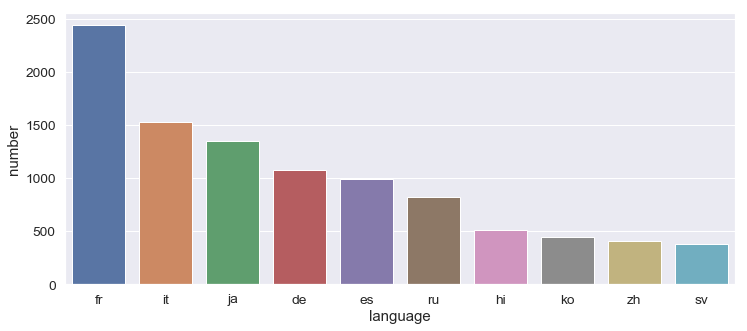

In [156]:
plt.figure(figsize=(12,5))
sns.barplot(x='language', y='number', data=lang_data.iloc[1:11])
plt.show()

In [157]:
data['popularity'].describe()

count     45461
unique    44176
top         0.0
freq         34
Name: popularity, dtype: object

In [158]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [159]:
data['popularity'] = data['popularity'].apply(clean_numeric).astype('float')
data['vote_count'] = data['vote_count'].apply(clean_numeric).astype('float')
data['vote_average'] = data['vote_average'].apply(clean_numeric).astype('float')

In [160]:
data['popularity'].describe()

count    45460.000000
mean         2.921478
std          6.005414
min          0.000000
25%          0.385948
50%          1.127685
75%          3.678902
max        547.488298
Name: popularity, dtype: float64

In [161]:
data['popularity'].fillna(data['popularity'].median())


0        21.946943
1        17.015539
2        11.712900
3         3.859495
4         8.387519
5        17.924927
6         6.677277
7         2.561161
8         5.231580
9        14.686036
10        6.318445
11        5.430331
12       12.140733
13        5.092000
14        7.284477
15       10.137389
16       10.673167
17        9.026586
18        8.205448
19        7.337906
20       12.669608
21       10.701801
22       11.065939
23       12.133094
24       10.332025
25        1.845899
26        8.681325
27        2.228434
28        9.822423
29        1.100915
           ...    
45436     1.270832
45437    20.821780
45438     0.590087
45439     0.143223
45440     0.767762
45441     4.392389
45442     0.219260
45443     1.618458
45444     0.208349
45445     0.148131
45446     0.725084
45447     0.213973
45448     0.071782
45449     2.568495
45450     1.109068
45451     0.225432
45452     0.011025
45453     1.559596
45454     0.139936
45455     0.225051
45456     0.222814
45457     0.

In [162]:
data['vote_count'].describe()

count    45460.000000
mean       109.897338
std        491.310374
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

In [163]:
data['vote_average'] = data['vote_average'].replace(0, np.nan)
data['vote_average'].describe()

count    42462.000000
mean         6.014877
std          1.256208
min          0.500000
25%          5.300000
50%          6.100000
75%          6.900000
max         10.000000
Name: vote_average, dtype: float64

In [164]:
data['vote_average'].fillna(data['vote_average'].median())

0        7.7
1        6.9
2        6.5
3        6.1
4        5.7
5        7.7
6        6.2
7        5.4
8        5.5
9        6.6
10       6.5
11       5.7
12       7.1
13       7.1
14       5.7
15       7.8
16       7.2
17       6.5
18       6.1
19       5.4
20       6.4
21       6.5
22       6.0
23       6.3
24       7.1
25       7.0
26       6.6
27       7.4
28       7.6
29       6.5
        ... 
45436    3.7
45437    8.3
45438    6.8
45439    5.8
45440    5.0
45441    5.2
45442    5.0
45443    7.6
45444    6.1
45445    4.5
45446    6.7
45447    6.0
45448    5.0
45449    5.4
45450    6.5
45451    6.5
45452    6.1
45453    6.6
45454    4.0
45455    6.0
45456    6.3
45457    7.0
45458    7.0
45459    3.5
45460    5.7
45461    4.0
45462    9.0
45463    3.8
45464    6.1
45465    6.1
Name: vote_average, Length: 45466, dtype: float64

In [165]:
data['status'].value_counts()

Released           45014
Rumored              230
Post Production       98
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

In [166]:
data['runtime'] = data['runtime'].astype('float')

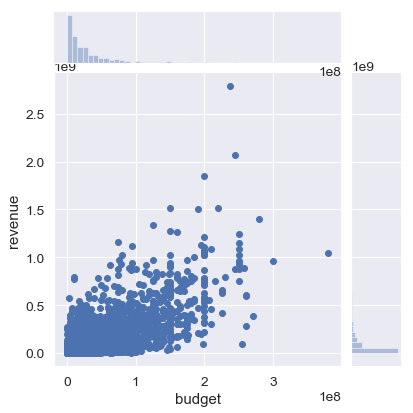

In [167]:
sns.jointplot(x='budget',y='revenue',data=data[data['return'].notnull()])

In [169]:
data['revenue'].describe()

count    7.408000e+03
mean     6.878739e+07
std      1.464203e+08
min      1.000000e+00
25%      2.400000e+06
50%      1.682272e+07
75%      6.722707e+07
max      2.787965e+09
Name: revenue, dtype: float64

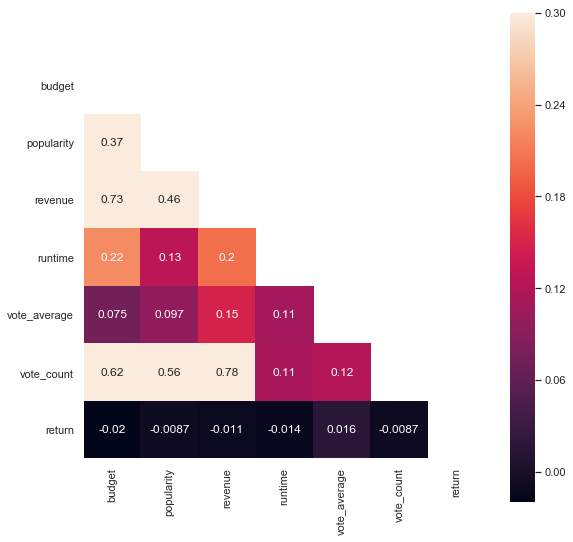

In [170]:
sns.set(font_scale=1)
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(9,9))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

In [171]:
s = data.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

In [172]:
gen_df = data.drop('genres', axis=1).join(s)

In [173]:
gen_df['genre'].value_counts().shape[0]

4069L

In [174]:
pop_gen = pd.DataFrame(gen_df['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']
pop_gen.head(10)

,genre,movies
0,"[{'id': 18, 'name': 'Drama'}]",5000
1,"[{'id': 35, 'name': 'Comedy'}]",3621
2,"[{'id': 99, 'name': 'Documentary'}]",2723
3,[],2442
4,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",1301
5,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1135
6,"[{'id': 27, 'name': 'Horror'}]",974
7,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",930
8,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",593
9,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",532


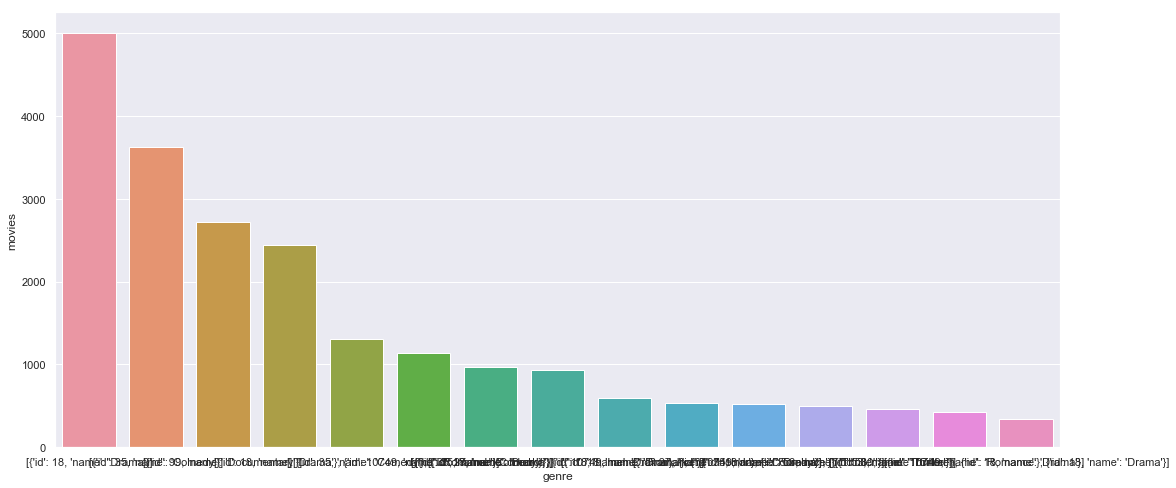

In [175]:
plt.figure(figsize=(18,8))
sns.barplot(x='genre', y='movies', data=pop_gen.head(15))
plt.show()

In [176]:
data.loc[data['original_language'].isnull(), 'original_language'] = 'en'
data.loc[data['budget'].isnull(), 'budget'] = '5000000.0 '
data.loc[data['popularity'].isnull(), 'popularity'] = '0.000000 '
data.loc[data['production_companies'].isnull(), 'production_companies'] = 'Metro-Goldwyn-Mayer'
data.loc[data['production_countries'].isnull(), 'production_countries'] = 'United States of America'
data.loc[data['revenue'].isnull(), 'revenue'] = '12000000.0'
data.loc[data['status'].isnull(), 'status'] = 'Released'
data.loc[data['video'].isnull(), 'video'] = 'False'
data.loc[data['vote_average'].isnull(), 'vote_average'] = '0.0'
data.loc[data['vote_count'].isnull(), 'vote_count'] = '1.0 '
data.loc[data['spoken_languages'].isnull(), 'spoken_languages'] = 'en'
data.loc[data['return'].isnull(), 'return'] = '1.000000'

In [177]:
data.drop(columns=['overview', 'tagline','title','runtime'], inplace=True)

In [178]:
data['return'] = data['return']. astype (float)
data['revenue'] = data['revenue']. astype (float)
data['budget'] = data['budget']. astype (float)

In [179]:
data.columns

Index([u'budget', u'genres', u'original_language', u'original_title',
       u'popularity', u'production_companies', u'production_countries',
       u'revenue', u'spoken_languages', u'status', u'video', u'vote_average',
       u'vote_count', u'return'],
      dtype='object')

In [649]:
selected_features = ['budget', 'revenue']

In [650]:
X = data[selected_features]

In [651]:
y = data['return']

In [652]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=311)

In [653]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [654]:
y_pred_train = regressor.predict(X_train)

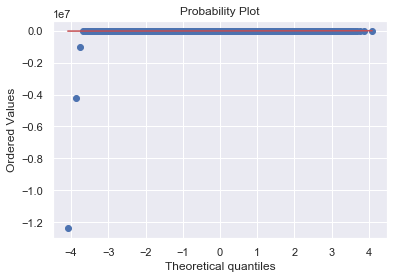

In [655]:
from scipy.stats import probplot

residuals = y_pred_train - y_train
_ = probplot(residuals, plot=plt)

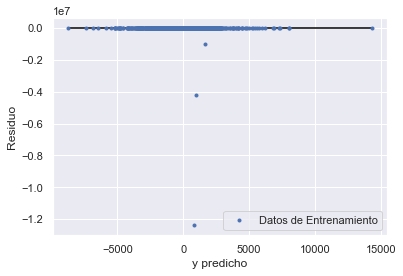

In [656]:
plt.plot(y_pred_train, residuals, '.', label="Datos de Entrenamiento")
plt.hlines(y = 0, xmin = min(y_pred_train), xmax = max(y_pred_train), color = 'black')
plt.xlabel('y predicho')
plt.ylabel('Residuo')
plt.legend(loc='best')

In [657]:
y_pred_test = regressor.predict(X_test)

In [658]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import probplot
import statsmodels.api as sm
import seaborn as sns


UnicodeDecodeError: 'ascii' codec can't decode byte 0xc3 in position 8: ordinal not in range(128)

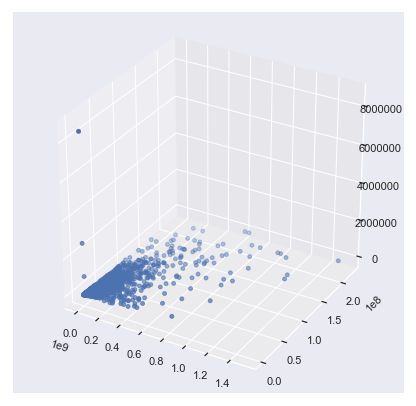

In [659]:
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection = '3d')
ax.scatter(X_test['revenue'], X_test['budget'], y_test, marker = '.', s=60, label = 'Datos Test')
ax.scatter(X_test['revenue'], X_test['budget'], y_pred_test, marker = '.', s=60, label = 'Predicción')

plt.xlabel('revenue')
plt.ylabel('budget')
ax.set_zlabel('return')
ax.view_init(200, 200)
plt.legend(loc='best')
plt.show()

In [ ]:
print('Error Cuadrático Medio (Mean Squared Error): %.8f' % mean_squared_error(y_test, y_pred_test))
print('Raíz del Error Cuadrático Medio (Root Mean Squared Error): %.8f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Coeficiente de Determinación (Coefficient of Determination): %.8f' % r2_score(y_test, y_pred_test))

In [ ]:
regressor.score(X_test, y_test)

In [ ]:
print('Vector de coeficientes de la función lineal: ', regressor.coef_)
print('Ordenada en el origen (W0): ', regressor.intercept_)

In [583]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)

In [584]:
X_scaled_train

array([[-0.19636033, -0.1469451 ],
       [-0.19636033, -0.1469451 ],
       [-0.19636033, -0.1469451 ],
       ...,
       [-0.19636033, -0.3301542 ],
       [-0.19636033, -0.1469451 ],
       [-0.19636033, -0.1469451 ]])

In [585]:
regressor = LinearRegression()
regressor.fit(X_scaled_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [586]:
y_pred_train = regressor.predict(X_scaled_train)

In [587]:
X_scaled_test = scaler.transform(X_test)
y_pred_test = regressor.predict(X_scaled_test)

In [588]:
print('Vector de coeficientes de la función lineal: ', regressor.coef_)
print('Ordenada en el origen (W0): ', regressor.intercept_)

('Vector de coeficientes de la funci\xc3\xb3n lineal: ', array([-687.49396355,  543.39036301]))
('Ordenada en el origen (W0): ', 556.0402552978873)


In [589]:

print('Error Cuadrático Medio (Mean Squared Error): %.8f' % mean_squared_error(y_test, y_pred_test))
print('Raíz del Error Cuadrático Medio (Root Mean Squared Error): %.8f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Coeficiente de Determinación (Coefficient of Determination): %.8f' % r2_score(y_test, y_pred_test))

Error Cuadrático Medio (Mean Squared Error): 5926021610.26574039
Raíz del Error Cuadrático Medio (Root Mean Squared Error): 76980.65737746
Coeficiente de Determinación (Coefficient of Determination): 0.00001748


Modelo de machine learning

In [235]:
from sklearn.model_selection import train_test_split 
import xgboost as xgb  #Libreria de algoriitmo de boosting, sive para hacer la prediccion
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split 

In [236]:
data1 = pd.get_dummies(data['status'], prefix='org_lang') 
data = pd.concat([data, data1], axis=1) 

In [273]:
data['retorno'] = data['return'] >  1.000000 
data['retorno_total'] = (data['retorno']==1).astype(int)

In [275]:
data['retorno'].value_counts()

False    41710
True      3756
Name: retorno, dtype: int64

In [246]:
data['retorno_total'].value_counts()

0    45466
Name: retorno_total, dtype: int64

In [184]:
y = data['retorno_total']

In [228]:
columns= [col for col in data.columns if col not in 
          ['production_companies','retorno_total','genres', 'original_language', 'original_title, popularity', 'production_countries', 'spoken_languages', 'status', 'video', 'vote_average', 'vote_count'
          'fields original_title','genres', 'popularity','return','original_title','vote_count','genres','original_language','spoken_languages']]


In [229]:
x = data[columns]

In [230]:
x_train, x_test, y_train, y_test = train_test_split(x,y)

In [231]:
def train(x_train,y_train):

    xgb_model = xgb.XGBClassifier()

    print("Comienza entrenamiento del modelo XGBoost")

    xgb_model.fit(x_train, y_train)

    print("Entrenamiento finalizado\n")

    print("Haciendo las predicciones\n\n")

    XGB_preds = xgb_model.predict(x_test)
    print(classification_report(y_test, XGB_preds))
    print(confusion_matrix(y_test, XGB_preds))
    return xgb_model

In [232]:
def predict(data_to_predict, xgb_model):
  
    print("\n\n-------------------------")
    print("Ingreso a la funcion de prediccion\n")

    XGB_preds = xgb_model.predict_proba(x)
    
    return XGB_preds

In [233]:
modelo = train(x_train, y_train)

Comienza entrenamiento del modelo XGBoost
Entrenamiento finalizado

Haciendo las predicciones


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11155
           1       1.00      1.00      1.00       212

   micro avg       1.00      1.00      1.00     11367
   macro avg       1.00      1.00      1.00     11367
weighted avg       1.00      1.00      1.00     11367

[[11155     0]
 [    0   212]]
